### Notes before we start

We want to create a plotting utility so we can easily plot and compare different matrices. We might move them to `hicstuff.py` for import, but as for now, they are defined only in this notebook.

## Setup

### Imports for plots etc

In [1]:
# import standard python libraries
import numpy as np
import pandas as pd

# Import packages for working with cooler files and tools for plots
import cooler
import cooltools.lib.plotting
import cooltools
import seaborn as sns
from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable



### `InlineBackend.rc`

For consistent plots that fit with pdf manus.

In [2]:
import matplotlib.pyplot as plt

# Define my params:
## Params will comply with my desired layout for the Manuscript (PDF)

notebook_rcparams = {
    'font.size': 7,
    'axes.titlesize': 8,
    'axes.labelsize': 7,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'figure.titlesize': 9,
    'figure.figsize': [6.0, 2.0],
    'figure.labelsize': 7,
    
}

# Apply config
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
%config InlineBackend.rc = notebook_rcparams

In [3]:
print({key:plt.rcParams[key] for key in notebook_rcparams.keys()})

{'font.size': 10.0, 'axes.titlesize': 'large', 'axes.labelsize': 'medium', 'xtick.labelsize': 'medium', 'ytick.labelsize': 'medium', 'figure.titlesize': 'large', 'figure.figsize': [6.4, 4.8], 'figure.labelsize': 'large'}


In [4]:
## Apparently IPython needs this twice to understand?? 
import matplotlib.pyplot as plt

# Define my params:
## Params will comply with my desired layout for the Manuscript (PDF)

notebook_rcparams = {
    'font.size': 7,
    'axes.titlesize': 8,
    'axes.labelsize': 7,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'figure.titlesize': 9,
    'figure.figsize': [6.0, 2.0],
    'figure.labelsize': 7,
}

# Apply config
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
%config InlineBackend.rc = notebook_rcparams

In [5]:
print({key:plt.rcParams[key] for key in notebook_rcparams.keys()})

{'font.size': 7.0, 'axes.titlesize': 8.0, 'axes.labelsize': 7.0, 'xtick.labelsize': 6.0, 'ytick.labelsize': 6.0, 'figure.titlesize': 9.0, 'figure.figsize': [6.0, 2.0], 'figure.labelsize': 7.0}


### Load all the coolers and eigenvectors

In [6]:
## Loading all coolers and their compartments
import glob
import os.path as op
import cooler

# Abbreviate the names (almost the same abbreviations as Wang et al. 2019)
names_abbr = {'fibroblast': 'Fib', 'spermatogonia': 'SPA', 'pachytene_spermatocyte': 'PAC', 'round_spermatid': 'RS', 'sperm': 'Sp'}

# Paths and resolutions
mcools = pd.Series(glob.glob("../steps/bwa/*/cool/*/*.mcool"))
res_100 = "::resolutions/100000"
res_500 = "::resolutions/500000"

# Create a DataFrame
clr_df = pd.DataFrame({
    'name': pd.concat([mcools.apply(lambda x: op.basename(op.dirname(x)))] * 3, ignore_index=True),
    'resolution': ['100'] * len(mcools) + ['ps500'] * len(mcools) + ['500'] * len(mcools),
    'mcool_path': pd.concat([mcools] * 3, ignore_index=True)
})

# Insert the 'sname' column (shortname/abbreviation) 
clr_df['sname'] = clr_df['name'].apply(lambda x: names_abbr[x])

# Create the 'cooler_id' column
clr_df['cooler_id'] = clr_df.apply(
    lambda row: cooler.Cooler(
        row['mcool_path'] + (res_100 if row['resolution'] in ['100', 'ps500'] else res_500)
        ),
    axis=1
)

# Determine parsing run (dirname 3 levels up PE or recPE)
clr_df['run'] = clr_df['mcool_path'].apply(lambda x: 'recPE' if 'rec' in x else 'PE')

# Add the 'nbins' column
clr_df['nbins'] = clr_df['cooler_id'].apply(lambda x: len(x.bins().fetch('chrX')))

# Add the path to the compartments (../results/{compartments,rec_compartments})
# make a comp_dir dict
comp_dirs = {
    'PE': '../results/compartments/',
    'recPE': '../results/rec_compartments/'
}

clr_df['e1_dict'] = clr_df.apply(
    lambda row: {view: pd.read_csv(op.join(
        comp_dirs[row['run']], f"{row['name']}_e1_{row['resolution']}kb_{view}.csv"
        ))['e1']
        if row['resolution'] != 'ps500' 
        else  pd.read_csv(op.join(
        comp_dirs[row['run']], f"{row['name']}_e1_100kb_{view}_smoothed.csv"
        ))['e1'] 
        for view in ['full', 'arms', '10Mb']},
    axis=1
)

# Now we have all the coolers and compartments ready for plotting (in semi-long format)
#clr_df
clr_df[['sname', 'resolution', 'nbins', 'run', 'e1_dict']].query('resolution == "ps500"')
#print(clr_df['e1_dict'].values)

,sname,resolution,nbins,run,e1_dict
10,PAC,ps500,1534,recPE,"{'full': [nan, nan, nan, nan, nan, nan, nan, n..."
11,SPA,ps500,1534,recPE,"{'full': [nan, nan, nan, nan, nan, nan, nan, n..."
12,Fib,ps500,1534,recPE,"{'full': [nan, nan, nan, nan, nan, -0.15077432..."
13,RS,ps500,1534,recPE,"{'full': [nan, nan, nan, nan, nan, nan, nan, n..."
14,Sp,ps500,1534,recPE,"{'full': [nan, nan, nan, nan, nan, -0.00698684..."
15,RS,ps500,1534,PE,"{'full': [nan, nan, nan, nan, nan, -0.17383142..."
16,SPA,ps500,1534,PE,"{'full': [nan, nan, nan, nan, nan, nan, nan, -..."
17,Sp,ps500,1534,PE,"{'full': [nan, nan, nan, -0.102536873416233, -..."
18,Fib,ps500,1534,PE,"{'full': [nan, nan, nan, -0.2342462339281897, ..."
19,PAC,ps500,1534,PE,"{'full': [nan, nan, nan, nan, nan, 0.595328434..."


### Load the genomic intervals

#### A-compartments

In [7]:
import pandas as pd
import os

# ECH regions and chromsizes
ech90 = pd.read_csv('../data/ech90_human_Mmul_10.csv').assign(length=lambda x: x.end - x.start)

chromsizes = (pd.read_csv(
    '../data/rheMac10.filtered.chrom.sizes', 
    sep='\t', 
    index_col='chrom', 
    header=None, 
    names=['chrom','size'])
.to_dict()['size']
)

# Directory containing your .csv files

comp_dirs = {
    'PE': '../results/compartments/',
    'recPE': '../results/rec_compartments/'
}

# Create a dictionary to store the comps
comps = {
    'PE': {},
    'recPE': {}
}

# Iterate over all .csv files in the directory
for run in comps.keys():
    comp_dir = comp_dirs[run]
    for filename in os.listdir(comp_dir):
        # We only want the .csv files and not e1 tracks
        if filename.endswith('.csv') and 'e1' not in filename:
            # Construct the full file path
            filepath = os.path.join(comp_dir, filename)
            
            # Load the CSV into a DataFrame
            # Use the filename (without extension) as the dictionary key
            key = filename.replace('_a_comp_coords_', '_')
            key = os.path.splitext(key)[0]
            comps[run][key] = pd.read_csv(filepath).assign(length=lambda x: x.end - x.start)

# The `comps` dictionary now contains the DataFrames
# Example usage:
comps['recPE']['round_spermatid_100kb_arms']


,chrom,start,end,resolution,length
0,chrX,900000,1600000,100000,700000
1,chrX,1700000,2600000,100000,900000
2,chrX,2900000,3100000,100000,200000
3,chrX,3200000,3500000,100000,300000
4,chrX,6600000,6700000,100000,100000
...,...,...,...,...,...
72,chrX,145400000,147100000,100000,1700000
73,chrX,147300000,147400000,100000,100000
74,chrX,148800000,149100000,100000,300000
75,chrX,149300000,151200000,100000,1900000


#### Edge intervals

In [8]:
import pandas as pd
import os

# Directory containing your .csv files
edge_dirs = {
    'PE': '../results/edges/',
    'recPE': '../results/rec_edges/'
}

edges = {
    'PE': {},
    'recPE': {}
}

# Iterate over all .csv files in the directories
for run in edges.keys():
    edge_dir = edge_dirs[run]    
    for filename in os.listdir(edge_dir):
        if filename.endswith('.csv'):  # Check for .csv files
            # Construct the full file path
            filepath = os.path.join(edge_dir, filename)
            
            # Load the CSV into a DataFrame
            # Use the filename (without extension) as the dictionary key
            key = filename.replace('_edges', '')
            key = os.path.splitext(key)[0]
            edges[run][key] = pd.read_csv(filepath).assign(length=lambda x: x.end - x.start)

# The `edges` dictionary now contains the DataFrames
print(edges.keys())
display(edges['recPE']['fibroblast_100kb_10Mb'])

#ech90 = pd.read_csv('../data/ech90_human_Mmul_10.csv')


dict_keys(['PE', 'recPE'])


,start,end,chrom,resolution,length
0,700000,900000,chrX,100000,200000
1,3300000,3500000,chrX,100000,200000
2,8200000,8400000,chrX,100000,200000
3,13300000,13500000,chrX,100000,200000
4,14900000,15100000,chrX,100000,200000
...,...,...,...,...,...
87,144400000,144800000,chrX,100000,400000
88,145400000,145600000,chrX,100000,200000
89,146700000,147100000,chrX,100000,400000
90,148800000,149000000,chrX,100000,200000


#### Baboons

In [9]:
# Load baboons

import pandas as pd
from genominterv import interval_collapse

hama_panu3 = pd.read_csv('../data/lift/papanu4/high_hama_papanu4.bed', sep='\t', index_col=False, header=None, names=['group','chrom', 'start', 'end'])

olive_panu3 = pd.read_csv('../data/lift/papanu4/high_olive_papanu4.bed', sep='\t', index_col=False, header=None, names=['group','chrom', 'start', 'end'])

baboon_df = pd.read_csv('../results/high_baboon_rhemac10.bed', sep='\t', index_col=False, header=None, names=['chrom', 'start', 'end', 'group', 'score'])

high_hama_ucsc = (interval_collapse(baboon_df.query('group == "high_hama"')).
             assign(group = "high_hama").
             query('chrom == "chrX"')
             )
high_olive_ucsc = (interval_collapse(baboon_df.query('group == "high_olive"')).
              assign(group = "high_olive").
              query('chrom == "chrX"')
              )

high_hama = pd.read_csv('../data/lift/rheMac10/high_hama_rhemac10.bed', sep='\t', index_col=False, header=None, names=['group','chrom', 'start', 'end'])

high_olive = pd.read_csv('../data/lift/rheMac10/high_olive_rhemac10.bed', sep='\t', index_col=False, header=None, names=['group','chrom', 'start', 'end'])

baboon_dict = {"P.hama": high_hama, "P.anubis": high_olive}


### Define a plotting utility for compartments and E1

This plots a group/subset of coolers and their respective E1 compartments. 

In [10]:
# We can vary the number of subplots based on the number of coolers
# We can vary the number of views for each cooler
# We can define the region (tuple) of the chromosome to plot (default chrX)

def plot_grouped(
    group: pd.DataFrame, 
    region: str = 'chrX', # or (chrom, start, end)
    include_compartments: bool = True,
    view_order: list[str] = ['10Mb', 'arms', 'full'], 
    figsize: tuple[float, float] = (6, 6)
) -> None:
    
    group = group.reset_index(drop=True)
    
    # Define the number of subplots based on the number of coolers
    f, axs = plt.subplots(1,group.shape[0],
        figsize=figsize, 
        sharex=True
    )

    # Logtransform the colorscale
    norm = LogNorm(vmax=0.1)

    # If there is only one cooler, axs is not a list, so we need to make it a list
    if not isinstance(axs, np.ndarray):
        axs = [axs]

    
    # Loop through the clrs and its matrix: plot the matrix on its axis
    for row in group.itertuples():
        ax = axs[row.Index]
        # Define the y-axis label
        title = f'{row.sname}{row.resolution}kb: {row.run}'
        ylab = f'{region}:{row.resolution}kb [Mb]'

        # Extract some variables
        e1_dict = {k: v for k, v in row.e1_dict.items() if k in view_order}
        chrom_start = row.cooler_id.bins().fetch(region)['start'].values
        chrom_end = row.cooler_id.bins().fetch(region)['end'].values

        im = ax.matshow(
            row.cooler_id.matrix().fetch(region),
            norm=norm,
            cmap='fall',
        );
        ax.set_xlim(0, row.nbins)
        ax.set_ylim(row.nbins, 0)
        ax.set_ylabel(ylab)
        ticks = np.linspace(0, row.nbins, 5)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f'{x*row.cooler_id.binsize/1_000_000:.0f}' for x in ticks])
        ax.xaxis.set_visible(False)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.05)
        plt.colorbar(im, cax=cax, label='corrected frequencies');
        # Only show the colorbar on the last plot and ytitle on first plot
        if row.Index != group.shape[0] - 1:
            cax.set_visible(False)
        elif row.Index != 0:
            ax.set_ylabel('')

        # Skip the E1 plot when
        if not include_compartments:
            ax.set_title(title)
            continue

        for j, (view, e1) in enumerate(e1_dict.items()):
            ax1 = divider.append_axes("top", size="10%", pad=0.1, sharex = ax)

            # Create stairs
            x = np.zeros(2*chrom_start.size)
            y = np.zeros(2*chrom_start.size)
            x[0::2] = chrom_start/row.cooler_id.binsize
            x[1::2] = chrom_end/row.cooler_id.binsize
            y[0::2] = e1
            y[1::2] = e1

            ax1.fill_between(x, y, 0, where=(y > 0), color='tab:red', ec = 'None')
            ax1.fill_between(x, y, 0, where=(y < 0), color='tab:blue', ec = 'None')

            ax1.set_ylabel(view, rotation=0, ha='right', va='center')
            ax1.set_ylim(-0.8, 0.8)
            ax1.set_yticks([])
            ax1.set_xticks([])
            ax1.spines[:].set_visible(False)

        ax1.set_title(title)
    f.set_layout_engine('compressed')
    plt.show()
    





### Plotting matrices separately

Plotting function that makes separate plots in stead of mpl.subplots. This makes it compatible with YAML header subfigures and layout options for embedding into Quarto

In [11]:
def plot_for_quarto(
    group: pd.DataFrame, 
    region: str | tuple[str, int, int] = 'chrX',
    include_compartments: bool = True,
    view_order: list[str] = ['10Mb', 'arms', 'full'], 
    figsize: tuple[float, float] = (6, 6),
    col_vmin: float = 1e-3,
    col_vmax: float = 0.1,
    save_png_name: str = None
) -> None:
    """
    Plot each cooler as a separate figure to allow Quarto YAML options for subfigure plots and captions.
    """
    group = group.reset_index(drop=True)

    # Scale figsize based on the number of coolers
    figsize = (figsize[0]/group.shape[0], figsize[1])

    # Set the region to a tuple if it is a string
    if isinstance(region, str):
        region = (region, 0, group.iloc[0].cooler_id.chromsizes[region])
    
    # Define start and end for the matrix plot
    start, end = region[1], region[2]

    # Loop through each cooler (row) in the DataFrame
    for row in group.itertuples():
        # Create a new figure for each cooler
        # Scale figsize
        fig, ax = plt.subplots(figsize=figsize)

        # Logtransform the colorscale
        norm = LogNorm(vmin=col_vmin,vmax=col_vmax)

        # Define the y-axis label
        # title = f'{row.sname}{row.resolution}kb: {row.run}'
        ylab = f'{row.resolution}kb'

        # Extract some variables
        e1_dict = {k: row.e1_dict[k] for k in view_order}
        chrom_start = row.cooler_id.bins().fetch(region)['start'].values
        chrom_end = row.cooler_id.bins().fetch(region)['end'].values
        nbins = chrom_start.size # != row.nbins when subsetting chr
        binsize = row.cooler_id.binsize # is used several times

        # Plot the Hi-C matrix
        im = ax.matshow(
            row.cooler_id.matrix().fetch(region),
            norm=norm,
            cmap='fall',
            extent=(0, nbins, nbins, 0)
        )
        ax.set_xlim(0, nbins)
        ax.set_ylim(nbins, 0)
        ax.set_ylabel(ylab)
        ticks = np.linspace(0, nbins, 5)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f'{(start/binsize+x)*binsize/1_000_000:.0f}' for x in ticks])
        ax.xaxis.set_visible(False)

        # Add a colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.05)
        plt.colorbar(im, cax=cax, label='corrected frequencies')

        # Skip E1 plot if not including compartments
        if include_compartments:
            for view, e1 in e1_dict.items():
                # subset the e1 to region (chrX:start-end)/binsize
                start_bin = int(chrom_start[0]/binsize)
                end_bin = int(chrom_start[-1]/binsize)
                e1 = e1.iloc[start_bin:end_bin+1].reset_index(drop=True)
                ax1 = divider.append_axes("top", size="10%", pad=0.05, sharex=ax)

                # Create stairs for E1 values
                x = np.zeros(2 * chrom_start.size)
                y = np.zeros(2 * chrom_start.size)
                x[0::2] = np.arange(chrom_start.size)
                x[1::2] = np.arange(chrom_start.size)
                y[0::2] = e1
                y[1::2] = e1

                ax1.fill_between(x, y, 0, where=(y > 0), color='tab:red', ec='None')
                ax1.fill_between(x, y, 0, where=(y < 0), color='tab:blue', ec='None')

                if len(e1_dict) > 1:
                    ax1.set_ylabel(view, rotation=0, ha='right', va='center', fontsize=7)
                else:
                    ax1.set_ylabel('E1', rotation=0, ha='right', va='center', fontsize=7)

                ax1.set_ylim(-0.8, 0.8)
                ax1.set_yticks([])
                ax1.set_xticks([])
                ax1.spines[:].set_visible(False)

        # # Set the figure title
            # ax1.set_title(title)
        
        fig.tight_layout()

        if save_png_name:
            plt.savefig(save_png_name, dpi=320)

        # Display the figure for Quarto to capture
        plt.show()



### Plot intervals

Plot genomic intervals as tracks (up to 3)

In [12]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from genominterv import interval_intersect


def plot_regions(query=None, annot=None, intersect=None, 
                 track_titles=['query', 'annot', 'intersect'], 
                 figsize=(10, 1),
                 title='chrom',
                 alpha=0.8, lw=0):
    chrom = annot['chrom'].unique()[0]
    chromsizes = pd.read_csv('../data/rheMac10.filtered.chrom.sizes', sep='\t', header=None, names=['chrom', 'size'])

    base_size = chromsizes[chromsizes['chrom'] == chrom]['size'].values[0]
    annot_size = annot['end'].max()
    query_size = query['end'].max()
    chromsize = max(base_size, annot_size, query_size)


    if title == 'chrom':
        title = chrom
    

    # Define the plot size

    f, ax = plt.subplots(figsize=figsize, sharex=True)

    ax.spines[:].set_visible(False)

    # Plot the annot
    # Iterate over each interval in the DataFrame
    for start, end in zip(annot['start'], annot['end']):
        rect = Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:red', linewidth=lw, alpha=alpha)
        ax.add_patch(rect)
        ax.spines['bottom'].set_visible(True)
        ax.set_ylabel(track_titles[1], rotation=0, labelpad=10, ha='right', va='center')

    
    divider = make_axes_locatable(ax)

    if query is not None:
        qax = divider.append_axes("top", size="100%", pad=0.05, sharex=ax)
        qax.xaxis.set_visible(False)
        # Plot the query
        for start, end in zip(query['start'], query['end']):
            rect = Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:blue', linewidth=lw, alpha=alpha)
            qax.add_patch(rect)
            qax.spines[:].set_visible(False)
            qax.set_yticks([]) 
            qax.set_title(title, loc='left')
            qax.set_ylabel(track_titles[0], rotation=0, labelpad=10, ha='right', va='center')
    
    if intersect is not None:
        iax = divider.append_axes("bottom", size="100%", pad=0.05, sharex=ax)
        # Invisible x-axis for 'annot' (intersect ie below) 
        ax.xaxis.set_visible(False)
        # Plot the intersect
        for start, end in zip(intersect['start'], intersect['end']):
            rect = Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:green', linewidth=lw, alpha=alpha)
            iax.add_patch(rect)
            iax.spines[:].set_visible(False)
            iax.set_yticks([]) 
            ax.spines['bottom'].set_visible(False)
            iax.spines['bottom'].set_visible(True)
            iax.set_ylabel(track_titles[2], rotation=0, labelpad=10, ha='right', va='center')



    ax.set_yticks([])
    ax.set_xlim(0, chromsize)
    ticks = np.linspace(0, chromsize, num=5)
    ax.set_xticks(ticks) 
    ax.set_xticklabels([f'{int(t/1e6)} Mbp' for t in ticks])
    f.tight_layout()
    plt.show()
    #plt.tight_layout()



### Make edges

In [42]:
def make_edges(df, resolution):
    start_edge = pd.DataFrame({
        'chrom': df['chrom'],
        'start': df.apply(lambda x: max(x['start'] - resolution, 0), axis=1),
        'end': df['start']+1*resolution,
        'resolution': resolution,
    })
    end_edge = pd.DataFrame({
        'chrom': df['chrom'],
        'start': df['end']-1*resolution,
        'end': df.apply(lambda x: min(x['end'] + resolution, chromsizes['chrX']), axis=1),
        'resolution': resolution,
    })

    return interval_collapse(pd.concat([start_edge, end_edge]).sort_values(['chrom', 'start', 'end'])).assign(resolution=resolution)



### Svedig tabel

In [13]:
all_tests = pd.read_csv('../results/all_tests.csv', index_col=0)

def svedig_tabel(orig_df, index, columns, values, 
                 cmap='Reds', col_order=None, col_snames=None):

    """
    Creates a styled pivot table from a DataFrame, filtering by significance, 
    applying a log transformation, and adding visual styling.

    Parameters:
    ----------
    orig_df : pd.DataFrame
        The original DataFrame containing data to be processed.
    index : str
        Column name to use as the row index in the pivot table.
    columns : str
        Column name to use as the column headers in the pivot table.
    values : str
        Column name whose values populate the pivot table cells.
    cmap : str, optional
        Colormap to use for the background gradient styling (default is 'Reds').

    Returns:
    -------
    pd.io.formats.style.Styler
        A styled DataFrame object with the pivot table, including gradient-based
        cell coloring, transparent NaN values, formatted numbers, and table styles.
    """
    
    df = (orig_df
     .assign(log10p=np.log10(all_tests.p))
     .loc[(all_tests.p < 0.05)]
     .pivot(index=index, columns=columns, values=values)
    )
    if col_order:
        col_bool = [x in df.columns for x in col_order]
        col_order = [x for x in col_order if x in df.columns]
        df = df[col_order]
    if col_snames:
        col_snames = [col_snames[i] for i,x in enumerate(col_bool) if x]
        df = df.rename(columns = {x:col_snames[i] for i,x in enumerate(df.columns.tolist())})
    else:
        df = df.rename(columns = {x:x.replace('_', '<br>') for x in df.columns.tolist()})
    df = (df.style
     .background_gradient(subset=df.columns, axis=None, cmap=cmap, vmin=0)
     .map(lambda x: 'color: transparent; background-color: transparent' if np.isnan(x) else '')
     .format('{:.3f}')
     .set_table_styles(
                {c: [{'selector': '', 
                      'props': [('min-width', '20px')],
                     }] for c in df.columns}, overwrite=False
     )
    )
    return df

In [14]:
print("That should be all the setup :-)")

That should be all the setup :-)


## Matrices / E1

### E1: RS100/500

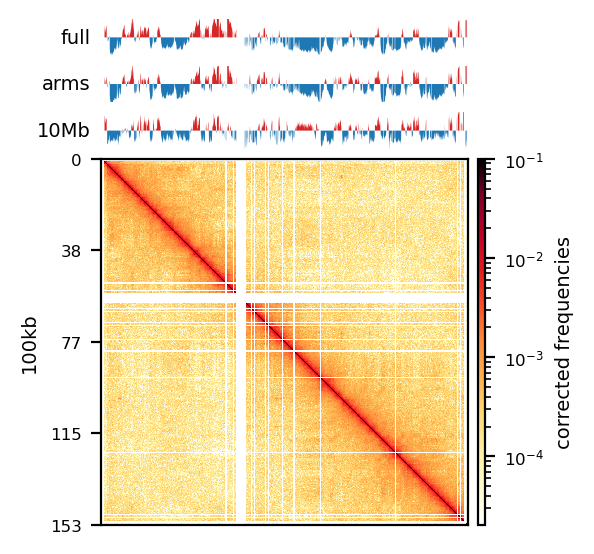

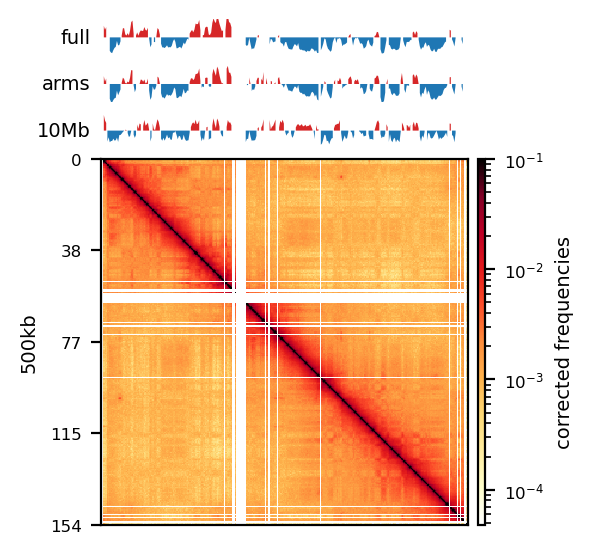

In [16]:
#| label: fig-e1-matrix-full-arms-10mb-round_spermatid
#| fig-cap: "E1 eigenvector values for merged round spermatid samples at a) 100kb or b) 500kb resolution, as well as the interaction matrix. E1 was restricted to either Full-chromosome (top), Chromosome-arms (middle), or 10Mb windows (bottom)"
#| fig-subcap: 
#|  - "100kb resolution"
#|  - "500kb resolution"
#| layout-ncol: 2

# Compare the compartments of the round_spermatid, 500kb, all views
res = ['100', '500']
name = ['round_spermatid']
run = ['recPE']

group = clr_df.query('name in @name and resolution in @res and run in @run')
plot_for_quarto(group)


### PE vs recPE (RS100kb)

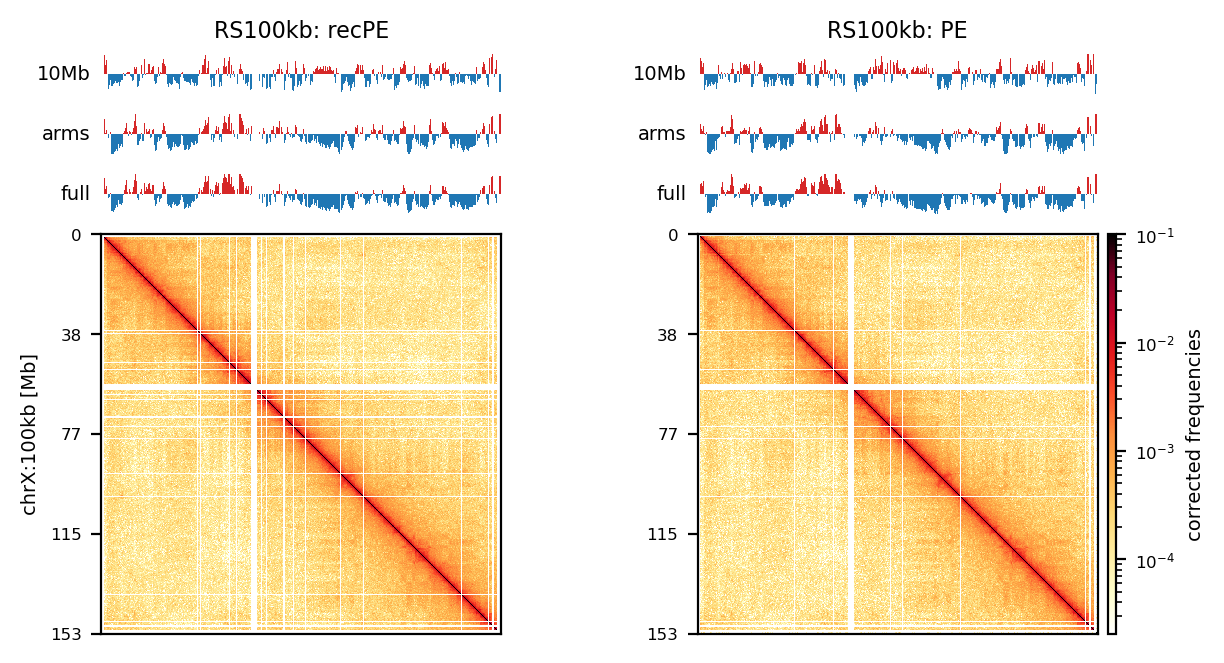

In [18]:
# Compare PE and recPE compartments for round_spermatid, 100kb

group = clr_df.query('resolution == "100" and name == "round_spermatid"')

plot_grouped(group, figsize=(6, 6))

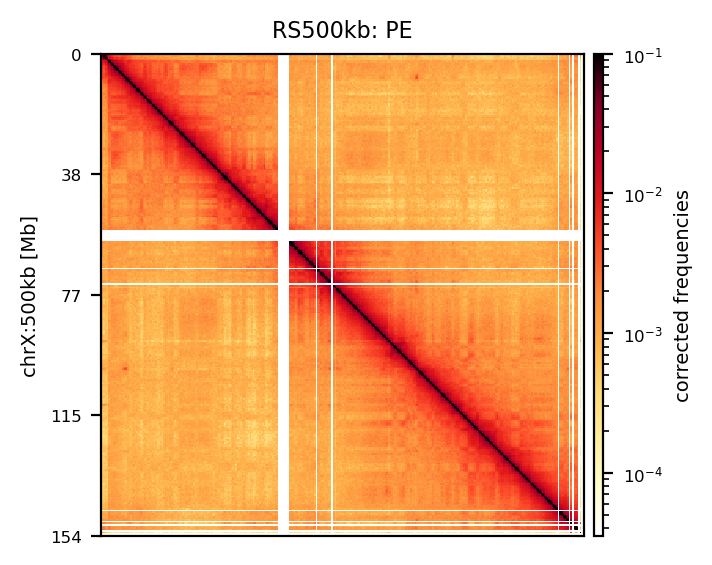

In [41]:
df = clr_df.query('resolution == "500" and name == "round_spermatid" and run == "PE"')

plot_grouped(df, include_compartments=False, figsize=(3, 3))

### PE vs. recPE: RS100kb

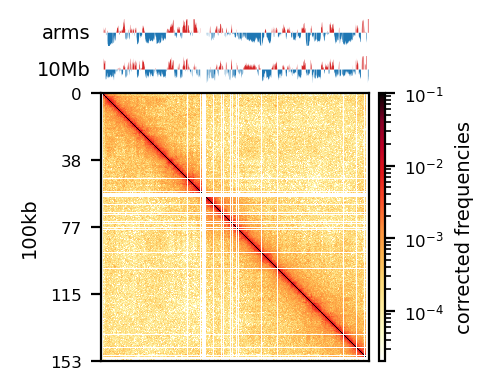

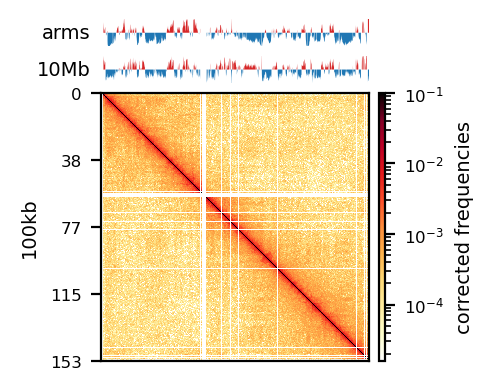

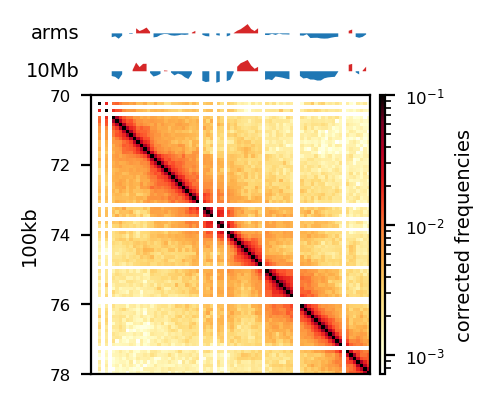

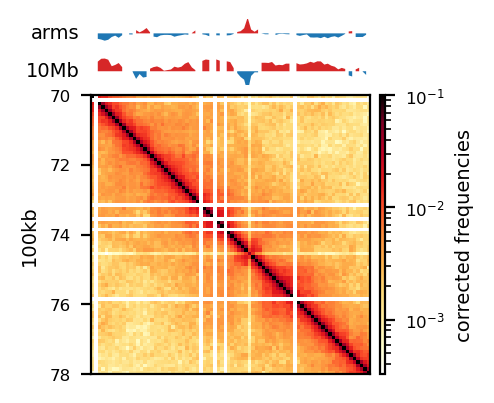

In [21]:
#| label: fig-rs100-recpe-pe
#| fig-cap: "Round Spermatid (RS) at 100kb, comparing the impact of parsing parameters"
#| fig-subcap:
#|   - "`5unique`: chrX:start-end"
#|   - "`mask`: chrX:start-end"
#|   - "`5unique`: chrX:70Mb-78Mb"
#|   - "`mask`: chrX:70Mb-78Mb"
#| layout: [[-0.5,5,5,-0.5],[-0.5,5,5,-0.5]]

df = clr_df.query('resolution == "100" and name == "round_spermatid"')

# Check the order of the group
#print(df[['name', 'resolution', 'run']].reset_index(drop=True))

plot_for_quarto(df, view_order=['10Mb','arms'], figsize=(5, 5))

start, end = 70_000_000, 78_000_000
region = ('chrX', start, end)
plot_for_quarto(df, region=region, include_compartments=True, view_order=['10Mb','arms'], figsize=(5, 5))

## Intervals

### PE/recPE compare compartments (100kb)

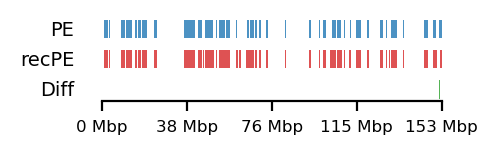

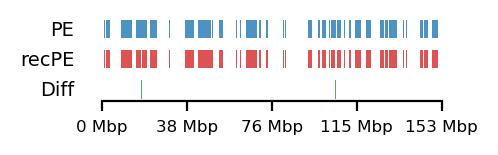

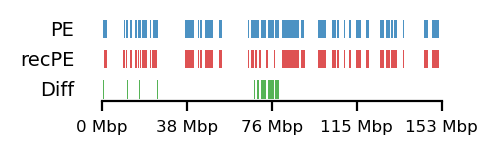

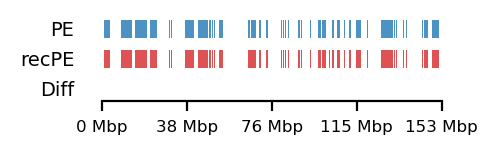

In [103]:
#| label: fig-rs-fb-100-pe-recpe-intervals
#| fig-cap: "Round Spermatid (RS) and Fibroblast (Fb) at 100kb, comparing the impact of parsing parameters on A-compartment calling at different viewframes; *arms*, *10Mb*. PE: initial parse (masking complex walks); recPE: recommended parse (reporting the 5'most unique alignment of a complex walk)."
#| fig-subcap:
#|   - "RS: arms"
#|   - "Fib: arms"
#|   - "RS: 10Mb"
#|   - "Fib: 10Mb"
#| layout: "[[-0.6,2.5,2.5,-0.6],[-0.6,2.5,2.5,-0.6]]"

from genominterv import interval_diff


### Plot the intervals and the diff between ### 

# Round Spermatid arms
query = comps['PE']['round_spermatid_100kb_arms']
annot = comps['recPE']['round_spermatid_100kb_arms']
plot_regions(query=query, annot=annot, 
             intersect=interval_diff(query, annot), 
             track_titles=['PE', 'recPE', 'Diff'],
             figsize=(2.5, 0.8),
             title=None)

# Fibroblast arms
query = comps['PE']['fibroblast_100kb_arms']
annot = comps['recPE']['fibroblast_100kb_arms']
plot_regions(query=query, annot=annot, 
             intersect=interval_diff(query, annot), 
             track_titles=['PE', 'recPE', 'Diff'],
             figsize=(2.5, 0.8),
             title=None)

# Round Spermatid 10Mb
query = comps['PE']['round_spermatid_100kb_10Mb']
annot = comps['recPE']['round_spermatid_100kb_10Mb']
plot_regions(query=query, annot=annot, 
             intersect=interval_diff(query, annot), 
             track_titles=['PE', 'recPE', 'Diff'],
             figsize=(2.5, 0.8),
             title=None)

# Fibroblast 10Mb
query = comps['PE']['fibroblast_100kb_10Mb']
annot = comps['recPE']['fibroblast_100kb_10Mb']
plot_regions(query=query, annot=annot, 
             intersect=interval_diff(query, annot), 
             track_titles=['PE', 'recPE', 'Diff'],
             figsize=(2.5, .8),
             title=None)


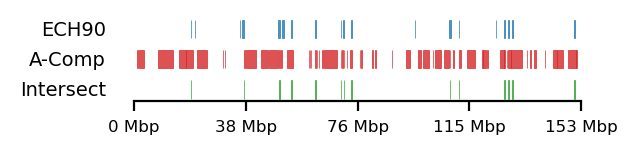

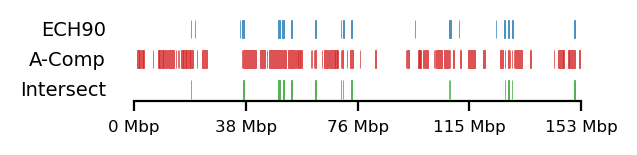

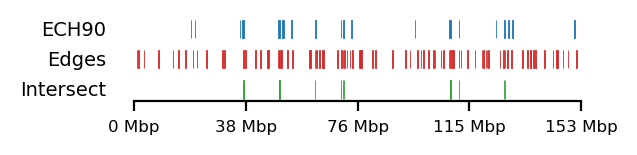

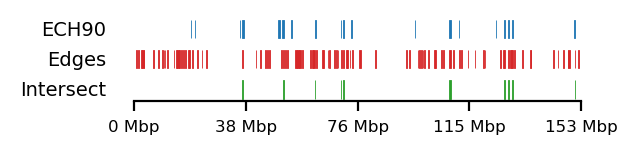

In [20]:
#| label: fig-comps-edges-ech
#| fig-cap: "Visual representation of the genomic intervals of ECH90, A-compartments (a+b), edges (c+d), and their intersections. Shown fibroblast (a+c) and round spermatid (b+d) at 100kb resolution and arms viewframe."
#| fig-subcap:
#|   - "Fibroblast A-compartments"
#|   - "Round Spermatid A-compartments"
#|   - "Fibroblast edges"
#|   - "Round Spermatid edges"
#| layout: "[[-0.05,3.2,3.2,-0.05],[-0.05,3.2,3.2,-0.05]]"


from genominterv import interval_intersect

query = ech90

fb_ann_comp = comps['recPE']['fibroblast_100kb_arms']
rs_ann_comp = comps['recPE']['round_spermatid_100kb_arms']
fb_ann_edge = edges['recPE']['fibroblast_100kb_arms']
rs_ann_edge = edges['recPE']['round_spermatid_100kb_arms']

size=(3.2, 0.8)

# Fib and RS compartments
plot_regions(query=query, annot=fb_ann_comp,
             intersect=interval_intersect(query, fb_ann_comp), 
             track_titles=['ECH90', 'A-Comp', 'Intersect'],
             figsize=size,
             title=None,
             lw=0.3)


plot_regions(query=query, annot=rs_ann_comp, 
             intersect=interval_intersect(query, rs_ann_comp), 
             track_titles=['ECH90', 'A-Comp', 'Intersect'], 
             figsize=size,
             title=None,
             lw=0.3)

# Fib and RS edges
plot_regions(query=query, annot=fb_ann_edge,
             intersect=interval_intersect(query, fb_ann_edge), 
             track_titles=['ECH90', 'Edges', 'Intersect'],
             figsize=size,
             title=None,
             lw=0.3, alpha=1)


plot_regions(query=query, annot=rs_ann_edge, 
             intersect=interval_intersect(query, rs_ann_edge), 
             track_titles=['ECH90', 'Edges', 'Intersect'],
             figsize=size,
             title=None,
             lw=0.3, alpha=1)


### Visualize ECH enrichment

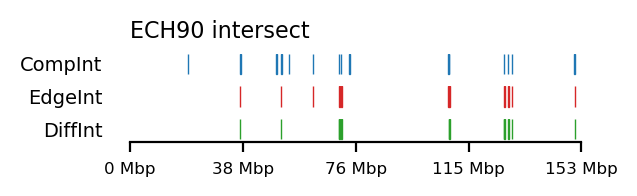

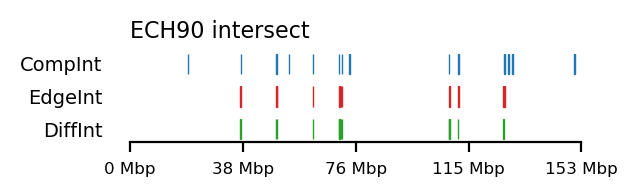

In [15]:
#| label: fig-edge-enrichment
#| fig-cap: "Visual representation of the enrichment of edges in the intersection of ECH90 and A-compartments. Shown round spermatid (a) and fibroblast (b) at 100kb resolution and arms viewframe. Note that the edge-regions are too small to be distinguished visually from the compartment on the graph, making it look like they overlap, even though the difference is reported."
#| fig-subcap:
#|   - "Round Spermatid"
#|   - "Fibroblast"
#| layout: "[-0.05,3.2,3.2,-0.05]"

from genominterv import interval_diff, interval_intersect, interval_union

complist = [comps['recPE']['round_spermatid_100kb_arms'],
            comps['recPE']['fibroblast_100kb_arms']]
edgelist = [edges['recPE']['round_spermatid_100kb_arms'],
            edges['recPE']['fibroblast_100kb_arms']]

for comp, edge in zip(complist, edgelist):
    int_comp = interval_intersect(ech90, comp)
    int_edge = interval_intersect(ech90, edge)

    diff_int_compedge = interval_diff(int_edge, int_comp)
    plot_regions(int_comp, int_edge, diff_int_compedge,
                track_titles=['CompInt', 'EdgeInt', 'DiffInt'],
                title="ECH90 intersect",
                figsize=(3.2, 1),
                alpha=1, lw=0.5)



### All 3 sets

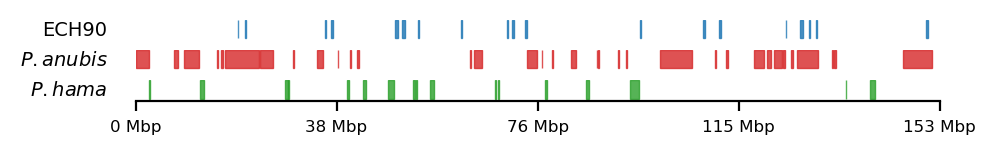

In [33]:
#| label: fig-introduce-selected-regions
#| fig-cap: "Visual representation of the selected regions for the baboon comparison. Shown are the ECH90 (top), high-olive (middle) and high-hama (bottom) regions, the basis of the comparison of genomic intervals in this analysis. All coordinates are lifted to the rheMac10 genome."


plot_regions(ech90, high_olive, high_hama,
             track_titles=['ECH90', r"$\it{P.anubis}$", r"$\it{P.hama}$"],
             figsize=(5, 0.8),
             title=None,
             lw=0.5, alpha=0.8)

### LiftOver comparison

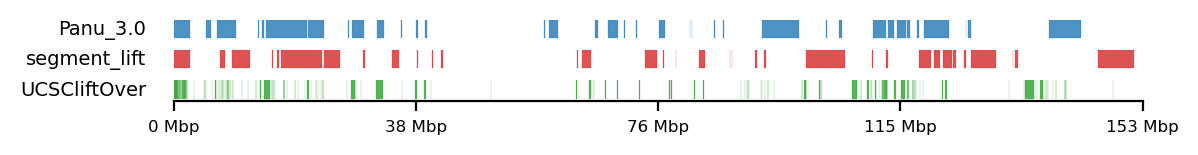

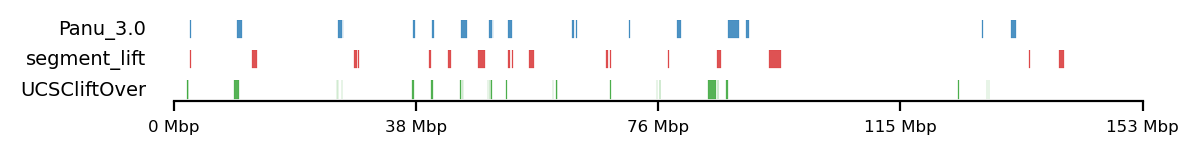

In [21]:
#| label: fig-compare-liftover
#| fig-cap: "Comparison of a) high-olive and b) high-hama intervals between Panu_3.0, segment_liftover, or UCSC liftOver coordinates when lifting from PapAnu4-->PapAnu3-->rheMac10."
#| fig-subcap:
#|   - "high-olive"
#|   - "high-hama"

track0 = [olive_panu3, hama_panu3]
track1 = [high_olive, high_hama]
track2 = [high_olive_ucsc, high_hama_ucsc]

for t0,t1,t2 in zip(track0, track1, track2):
    plot_regions(t0,t1,t2,
                track_titles=['Panu_3.0', 'segment_lift','UCSCliftOver'],
    #            title='High Olive Ancestry Intervals',
                title=None,
                figsize=(6, 0.8),
                alpha=0.8, lw=0.1)



### Baboon-rs100-intersect

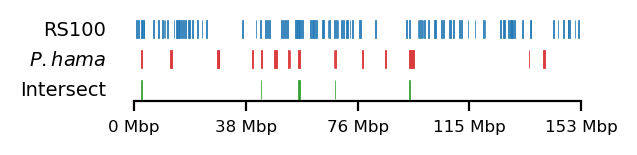

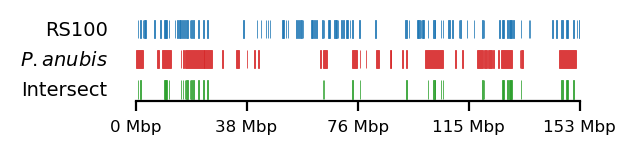

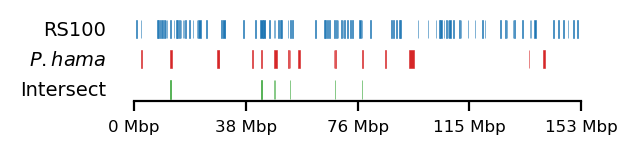

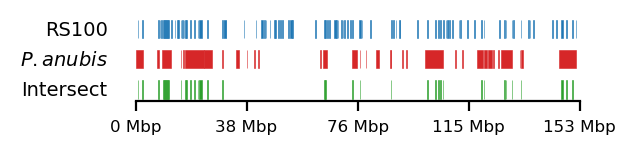

In [26]:
#| label: fig-baboon-rs100-intersect
#| fig-cap: "Comparing the A-compartment edges of round spermatid (RS) with regions in baboons from hybrid population where a) 95% of sampled individuals have *Papio hamadryas* ancestry or b) 100% of the samples have *Papio anubis* ancestry. The regions are extracted and lifted from PapAnu4 to rhemac10 using segment_liftover."
#| fig-subcap:
#|   - "*P. hamadryas* + arms E1"
#|   - "*P. anubis* + arms E1"
#|   - "*P. hamadryas* + 10Mb E1"
#|   - "*P. anubis* + 10Mb E1"
#| layout: "[[-0.05,3.2,3.2,-0.05],[-0.05,3.2,3.2,-0.05]]"

# Plot 

size = (3.2, 0.8)
edge_rs = edges['recPE']['round_spermatid_100kb_arms']

for name,group in baboon_dict.items():
    plot_regions(query=edge_rs, annot=group, 
                 intersect=interval_intersect(edge_rs, group), 
                 #intersect=ech90,
                 track_titles=['RS100', fr"$\it{{{name}}}$", 'Intersect'],
                 figsize=size,
                 title=None,
                 lw=0.3, alpha=0.9)
    
edge_rs = edges['recPE']['round_spermatid_100kb_10Mb']

for name,group in baboon_dict.items():
    plot_regions(query=edge_rs, annot=group, 
                 intersect=interval_intersect(edge_rs, group), 
                 #intersect=ech90,
                 track_titles=['RS100', fr"$\it{{{name}}}$", 'Intersect'],
                 figsize=size,
                 title=None,
                 lw=0.2, alpha=1)


### Table: Test 1bp limits

In [77]:
all_tests.head() #.query('query == "hama_edge_1bp"')

,tissue,pc_scale,query,annot,test,value,p,-log10p
0,fibroblast,arms,ECH90,comp_edge_1bp,jaccard,0.000002,0.01656,1.780940
1,fibroblast,arms,hama_edge_1bp,comp_edge_1bp,proximity,0.221717,0.88421,0.053445
2,fibroblast,arms,olive_edge_1bp,comp_edge_1bp,proximity,0.243643,0.67235,0.172405
3,fibroblast,arms,olivehama_edge_1bp,comp_edge_1bp,proximity,0.243643,0.74099,0.130188
4,fibroblast,10Mb,ECH90,comp_edge_1bp,jaccard,0.080105,0.02146,1.668370


In [41]:
#| label: tbl-all-tests
tissue_order = ['fibroblast', 'spermatogonia', 'pachytene_spermatocyte', 'round_spermatid', 'sperm']
tissue_sname = ['Fb', 'Spa', 'Pac', 'RS', 'Sperm']


t0 = (svedig_tabel(all_tests
                   .map(lambda x: x.replace('_edge_1bp', '') if isinstance(x, str) else x)
                   .rename(columns={'pc_scale': 'viewframe'}),
             index=['viewframe', 'test','query'],
             columns=["tissue"],
             col_order = tissue_order,
             col_snames = tissue_sname,
             values='p',
             cmap='Reds_r')
)

t1 = (svedig_tabel(
    all_tests
    .map(lambda x: x.replace('_edge_1bp', '') if isinstance(x, str) else x)
    .query('pc_scale == "arms"'),
    index=['test','query'],
    columns=["tissue"],
    col_order = tissue_order,
    col_snames = tissue_sname,
    values='p',
    cmap='Reds_r')
#.relabel_index(labels=[lbl for lbl in tissue_sname if lbl in t1.columns], axis=1)
)

t2 = (svedig_tabel(all_tests
                   .map(lambda x: x.replace('_edge_1bp', '') if isinstance(x, str) else x)
                   .query('pc_scale == "10Mb"'),
             index=['test','query'],
             columns=["tissue"],
             col_order = tissue_order,
             col_snames = tissue_sname,
             values='p',
             cmap='Reds_r')
)


display(t0)

In [38]:
#| label: tbl-svedig-tabel-significant
#| tbl-cap: "Test results from proximity and Jaccard, comparing ECH (full regions) or baboon 1bp limits with compartment 1bp limits from all cell types. Significant p-values across tissue types. All insignificant p-values are filtered out. *Fb: Fibroblast, Spa: Spermatogonia, Pac: Pachytene Spermatocyte, RS: Round Spermatid, Sperm: Sperm*"



tissue_order = ['fibroblast', 'spermatogonia', 'pachytene_spermatocyte', 'round_spermatid', 'sperm']
tissue_sname = ['Fb', 'Spa', 'Pac', 'RS', 'Sperm']



df = (all_tests
      .map(lambda x: x.replace('_edge_1bp', '_1bp') if isinstance(x, str) else x)
      .assign(log10p=np.log10(all_tests.p))
      .loc[(all_tests.p < 0.05)]
      .pivot(index=['pc_scale', 'query', 'test' ], columns=["tissue"], values="p").
      filter(tissue_order)
)

df = df.rename(columns = {x:tissue_sname[i] for i,x in enumerate(df.columns.tolist())})
df.columns.name = None
df = df.reset_index().fillna('-')
df = df.rename(columns={'pc_scale': 'View', 'query': 'Query', 'test': 'Test'})
df.style.hide(axis='index')

View,Query,Test,Fb,Spa,Pac,RS,Sperm
10Mb,ECH90,jaccard,0.021460,0.006110,-,-,0.047500
10Mb,olive_1bp,proximity,-,-,-,-,0.016140
10Mb,olivehama_1bp,proximity,-,0.018790,0.012300,-,0.001280
arms,ECH90,jaccard,0.016560,0.006120,0.005340,0.027690,-
arms,olivehama_1bp,proximity,-,-,0.035640,-,-


## Figures for the defence

In [15]:
%config InlineBackend.figure_formats = ['retina']

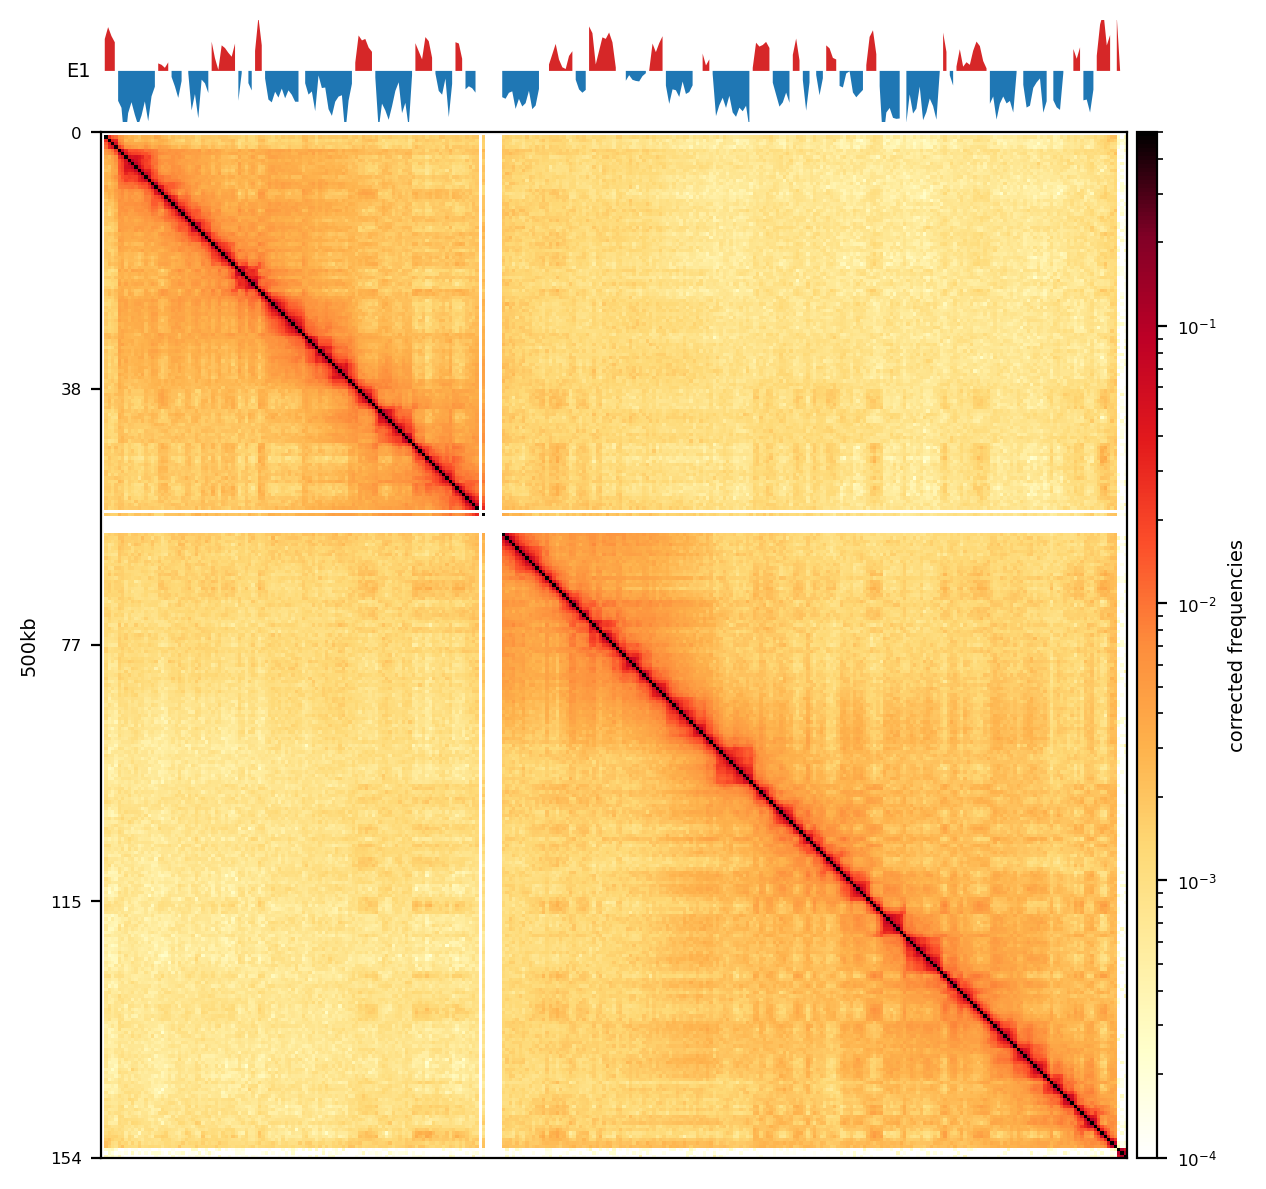

In [27]:
#| label: hic-example

group = clr_df.query('name == "sperm" and resolution == "500" and run == "recPE"')

slide_path = "../slides/images/hic-example.png"

plot_for_quarto(group, view_order=['10Mb'],
                col_vmin=1e-4, col_vmax=0.5,
                save_png_name=slide_path)

### Introduce selected regions

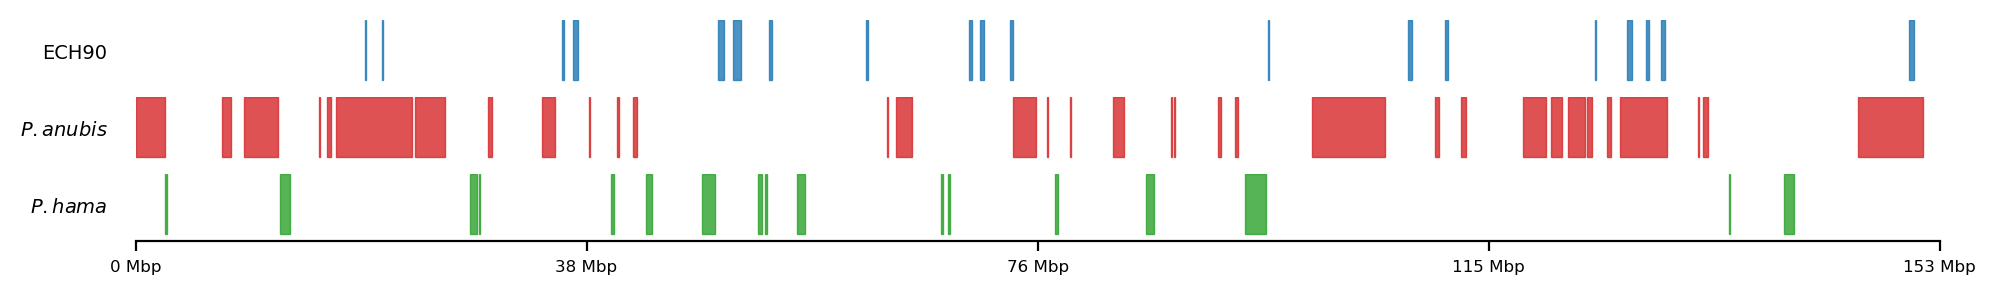

In [ ]:
#| label: introduce-selected-regions-slides


plot_regions(ech90, high_olive, high_hama,
             track_titles=['ECH90', r"$\it{P.anubis}$", r"$\it{P.hama}$"],
             figsize=(10, 1.5),
             title=None,
             lw=0.5, alpha=0.8)

### Compare liftover

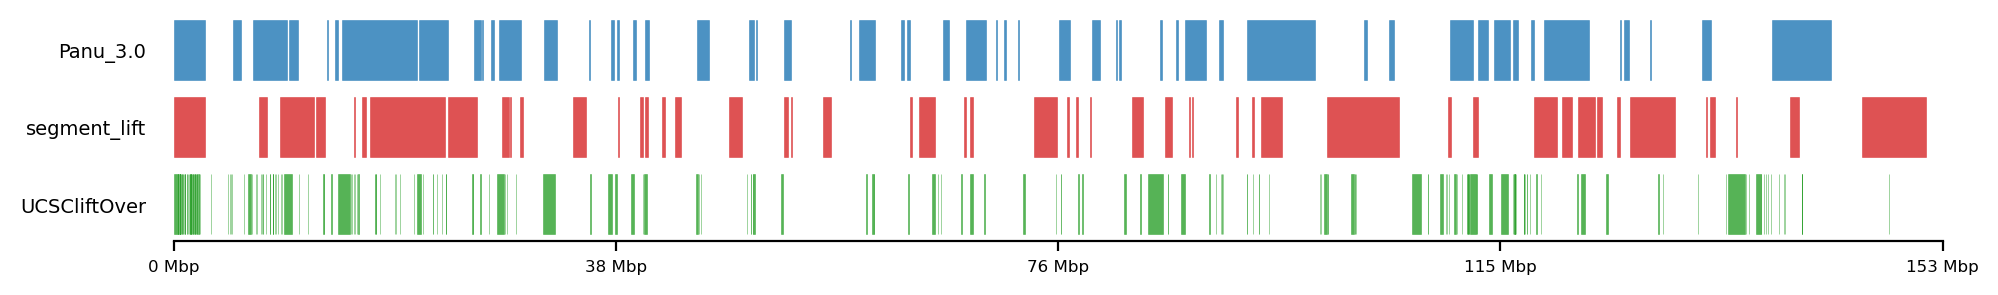

In [38]:
#| label: compare-liftover-slides
#| fig-subcap:
#|   - "high-olive"
#|   - "high-hama"

from genominterv import interval_union

track0 = [olive_panu3, hama_panu3]
track1 = [high_olive, high_hama]
track2 = [high_olive_ucsc, high_hama_ucsc]

track0 = [interval_union(olive_panu3, hama_panu3)]
track1 = [interval_union(high_olive, high_hama)]
track2 = [interval_union(high_olive_ucsc, high_hama_ucsc)]

for t0,t1,t2 in zip(track0, track1, track2):
    plot_regions(t0,t1,t2,
                track_titles=['Panu_3.0', 'segment_lift','UCSCliftOver'],
    #            title='Baboon Intervals',
                title=None,
                figsize=(10, 1.5),
                alpha=0.8, lw=0.2)

### ECH S100 limit intersect

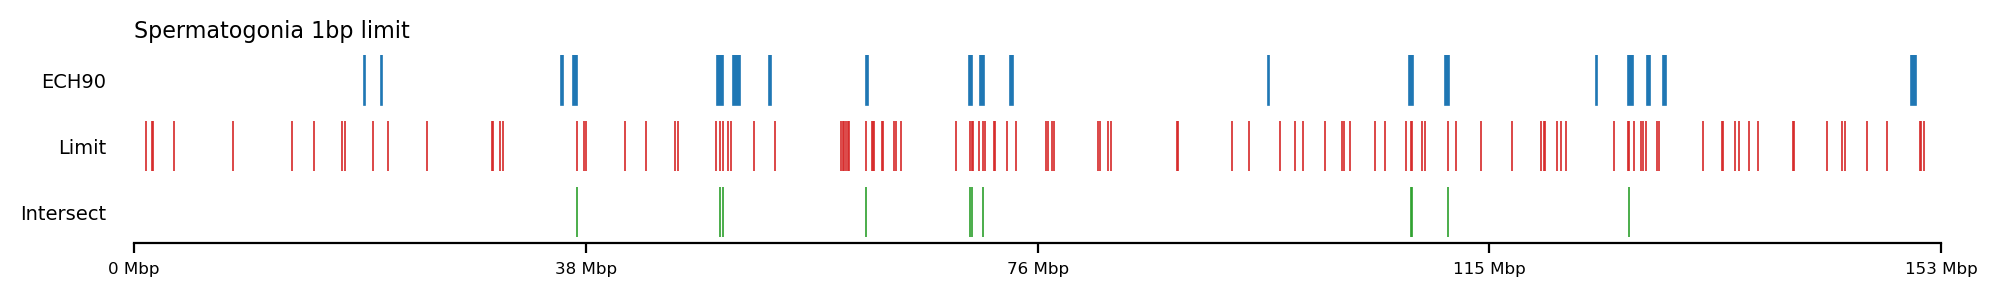

In [48]:

annot = make_edges(comps['recPE']['fibroblast_100kb_arms'], 2)
query = ech90

plot_regions(query=query, annot=annot,
             intersect=interval_intersect(query, annot),
             track_titles=['ECH90', 'Limit', 'Intersect'],
             figsize=(10, 1.5),
             title="Spermatogonia 1bp limit",
             lw=0.6, alpha=1)



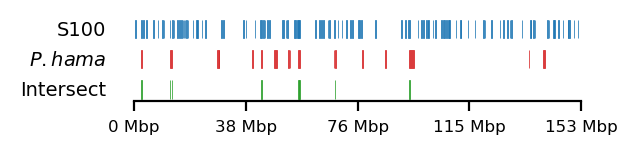

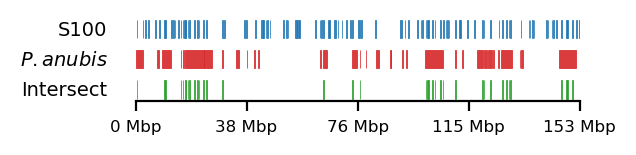

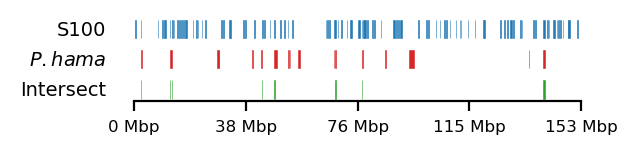

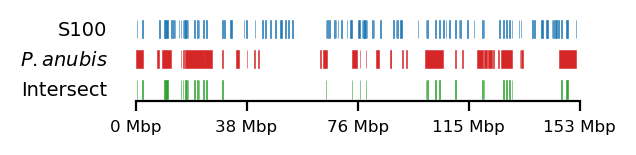

In [28]:
#| label: fig-baboon-s100-intersect
#| layout: "[[-0.05,3.2,3.2,-0.05],[-0.05,3.2,3.2,-0.05]]"

# Plot 

size = (3.2, 0.8)
edge_rs = edges['recPE']['sperm_100kb_arms']

for name,group in baboon_dict.items():
    plot_regions(query=edge_rs, annot=group, 
                 intersect=interval_intersect(edge_rs, group), 
                 #intersect=ech90,
                 track_titles=['S100', fr"$\it{{{name}}}$", 'Intersect'],
                 figsize=size,
                 title=None,
                 lw=0.3, alpha=0.9)
    
edge_rs = edges['recPE']['sperm_100kb_10Mb']

for name,group in baboon_dict.items():
    plot_regions(query=edge_rs, annot=group, 
                 intersect=interval_intersect(edge_rs, group), 
                 #intersect=ech90,
                 track_titles=['S100', fr"$\it{{{name}}}$", 'Intersect'],
                 figsize=size,
                 title=None,
                 lw=0.2, alpha=1)